In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import mediapipe as mp 
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras import losses

from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop, SGD, Adagrad, Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization ,Activation 
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dense,InputLayer ,Conv2D ,MaxPool2D
from tensorflow.keras import regularizers

sahpe of the image it should be 500 500
the results <class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 0.52488416  0.64733529 -0.18053333]
478
the shape of the it  (93, 3)


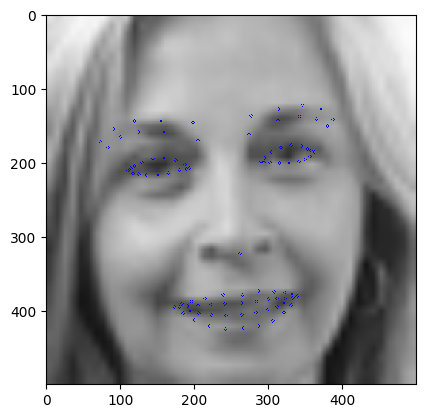

In [2]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
LEFT_EYE = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
RIGHT_EYE = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))
LEFT_EYEBROW = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYEBROW)))
RIGHT_EYEBROW = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYEBROW)))
LIPS = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LIPS)))
CONTOURS = list(set(itertools.chain(*mp_face_mesh.FACEMESH_CONTOURS)))
OTHER = [1]
face_mesh = mp_face_mesh.FaceMesh(  
                                    static_image_mode=True,
                                    max_num_faces=1,
                                    refine_landmarks=True,
                                    min_detection_confidence=0.5)
img=cv2.imread('final_data/1/test/happy/im1023.png')
#img=cv2.imread(df['image_path'][1])
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500, 500)) # Any size, just for visualization
img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
img_shape = img.shape[0]
print("sahpe of the image it should be 500",img_shape)
results = face_mesh.process(img)
print("the results",results)
annotated_image = img.copy()
shape = [(lmk.x, lmk.y, lmk.z) for i, lmk in enumerate(results.multi_face_landmarks[0].landmark)]

shape = np.array(shape)
print(shape[1])
print("======")
print(len(shape))  #x,y,z #this after normalization
shape = shape[LEFT_EYE + RIGHT_EYE + LEFT_EYEBROW + RIGHT_EYEBROW + LIPS + OTHER]
print("the shape of the it ",shape.shape)
for lmk in shape:
    cv2.circle(annotated_image, (int(lmk[0] * img_shape), int(lmk[1] * img_shape)), 2, (0, 0, 255))
plt.imshow(annotated_image, interpolation='nearest')

In [3]:
import os

PTH = 'final_data/1'
train_path = f'{PTH}/train'  
test_path = f'{PTH}/test'

def euc2d(a, b): # in 2d dimension
    return np.sqrt( (a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]) )

def euc3d(a, b):#in third dimension
    return np.sqrt( (a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]) + (a[2]-b[2])*(a[2]-b[2]) )

def prepare_csv(path, mode, face_mesh):
    
    emotions = os.listdir(path) #all directores of the train or the test the emotion exactly
    
    df = pd.DataFrame({
    #he choose the 92 becouse the range(5) => 0-4 so it will be acually a 5 number 
    # *2  is to be x and y 
    }, columns = [f"{i}" for i in range(92 * 2)] + ["y"])
    
    
    for i, emotion in enumerate(emotions): #also i we make it as labels
        images = os.listdir(f'{path}/{emotion}')
        for image in images:
            #pre process of the image
            img = cv2.imread(f"{path}/{emotion}/{image}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            
            results = face_mesh.process(img)
        
            if results.multi_face_landmarks:
        
                shape = [(lmk.x, lmk.y, lmk.z) for lmk in results.multi_face_landmarks[0].landmark]
                shape = np.array(shape) #all thing
                nose = shape[1] #the nose of the shape
                shape = shape[LEFT_EYE + RIGHT_EYE + LEFT_EYEBROW + RIGHT_EYEBROW + LIPS] 
                #the interested indexes from the landmark 

                distances2d = [round(euc2d(nose, x), 6) for x in shape]
                distances3d = [round(euc3d(nose, x), 6) for x in shape]

                df.loc[len(df)] = distances2d + distances3d + [i] #need more inveseitigation
            
    df.to_csv(f'{mode}.csv', index=False)


prepare_csv(train_path, 'train', face_mesh)
prepare_csv(test_path, 'test', face_mesh)

In [5]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [6]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,y
0,0.272684,0.281922,0.286502,0.286194,0.281755,0.255884,0.274561,0.252824,0.260394,0.277741,...,0.250468,0.233981,0.221699,0.280742,0.230604,0.255063,0.283277,0.268258,0.290345,0.0
1,0.268201,0.289599,0.308626,0.327322,0.339202,0.323666,0.353431,0.238810,0.249656,0.346796,...,0.251481,0.230786,0.215607,0.277543,0.244405,0.268910,0.290060,0.283698,0.305318,0.0
2,0.277561,0.287664,0.293336,0.294729,0.291891,0.267226,0.287668,0.259086,0.265496,0.289042,...,0.216529,0.199118,0.185075,0.225700,0.190018,0.219478,0.240996,0.233836,0.258214,0.0
3,0.194744,0.213043,0.229363,0.244633,0.253874,0.240521,0.263894,0.168621,0.178495,0.259516,...,0.197651,0.178368,0.165265,0.252614,0.186037,0.211087,0.249549,0.226084,0.257770,0.0
4,0.308835,0.324621,0.342762,0.363596,0.377185,0.356121,0.392978,0.286983,0.295547,0.385793,...,0.221461,0.206004,0.194852,0.258912,0.201212,0.225362,0.258494,0.241436,0.261619,0.0


In [7]:
df_test.head()


,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,y
0,0.302559,0.327992,0.348289,0.363965,0.370780,0.340805,0.375985,0.264102,0.278041,0.373913,...,0.207122,0.194471,0.186865,0.234223,0.191859,0.211213,0.234802,0.225195,0.256240,0.0
1,0.265797,0.276679,0.285063,0.289790,0.288735,0.260142,0.284660,0.246649,0.253845,0.286644,...,0.234675,0.216681,0.202295,0.281858,0.227564,0.247777,0.284405,0.258413,0.285954,0.0
2,0.347383,0.368923,0.386919,0.402509,0.410741,0.381482,0.420179,0.315513,0.327111,0.415759,...,0.242899,0.227048,0.214376,0.239986,0.206334,0.236604,0.260960,0.256214,0.283427,0.0
3,0.323400,0.347935,0.369312,0.388555,0.398958,0.372846,0.410253,0.288799,0.301414,0.404912,...,0.205358,0.181314,0.162215,0.254885,0.205221,0.232125,0.258388,0.246226,0.278803,0.0
4,0.308772,0.325831,0.340427,0.354172,0.362073,0.335812,0.370854,0.281372,0.291647,0.366761,...,0.232714,0.219975,0.211230,0.279206,0.230658,0.244644,0.271023,0.254032,0.278633,0.0


In [8]:
df_train.shape

(22453, 185)

In [9]:
df_test.shape

(5660, 185)

In [10]:
datagen = ImageDataGenerator(
                        brightness_range=[0.1, 1.5],
                        rotation_range=5, # rotate the image 30 degrees
                        width_shift_range=0.1, # Shift the pic width by a
                        height_shift_range=0.1, # Shift the pic height by
                        rescale=1./255, # Rescale the image by normalzing
                        shear_range=0.2, # Shear means cutting away part o
                        zoom_range=0.3, # Zoom in by 20% max
                        horizontal_flip=True, # Allow horizontal flipping
                        fill_mode='nearest', # Fill in missing pixels with
                        validation_split=0.3

)

In [11]:
batch_size = 32
image_size = (48, 48)  # Target image size

train_generator = datagen.flow_from_directory(
    'final_data/1/train/',
    target_size=image_size,
    batch_size=batch_size,
    color_mode = "rgb",
    class_mode='categorical',
    subset='training'       # 'training' or 'validation'
    
)
validation_generator = datagen.flow_from_directory(
    'final_data/1/train',
    target_size=image_size,
    batch_size=batch_size,
    color_mode = "rgb",
    class_mode='categorical',
    subset='validation'  
)

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.


In [12]:
train_n = train_generator.n
val_n = validation_generator.n
image_shape=(48,48,3)
model = Sequential()
model.add(InputLayer(input_shape=image_shape))

# 1 CONVOLUTIONAL LAYER
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation=activations.swish))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation=activations.swish))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation=activations.swish))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation=activations.swish))

# POOLING LAYER
model.add(MaxPool2D(pool_size=(3, 3)))

# 2 CONVOLUTIONAL LAYER
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation(activation=activations.swish))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())

model.add(Dense(512, activation='swish'))
model.add(Dense(256, activation='swish'))
model.add(Dense(7, activation='softmax'))
model.compile(loss = losses.CategoricalCrossentropy(),
                        optimizer = Adam(learning_rate=0.0003),
                        metrics = ['accuracy'])
results = model.fit(train_generator, epochs=100,
                    steps_per_epoch=train_n//batch_size,
                    validation_data=validation_generator,
                    validation_steps=val_n//batch_size)
model.save('best_fer_model.h5')

e:\Anaconda\envs\llm\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
e:\Anaconda\envs\llm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2433 - loss: 1.9242

e:\Anaconda\envs\llm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


628/628 ━━━━━━━━━━━━━━━━━━━━ 2467s 4s/step - accuracy: 0.2434 - loss: 1.9240 - val_accuracy: 0.2903 - val_loss: 1.7336
Epoch 2/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step - accuracy: 0.2812 - loss: 1.7452 - val_accuracy: 0.5000 - val_loss: 1.8111
Epoch 3/100


e:\Anaconda\envs\llm\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


628/628 ━━━━━━━━━━━━━━━━━━━━ 226s 360ms/step - accuracy: 0.3218 - loss: 1.6864 - val_accuracy: 0.3888 - val_loss: 1.5613
Epoch 4/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.3750 - loss: 1.4320 - val_accuracy: 0.5000 - val_loss: 1.7472
Epoch 5/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 224s 357ms/step - accuracy: 0.3961 - loss: 1.5408 - val_accuracy: 0.4406 - val_loss: 1.4413
Epoch 6/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - accuracy: 0.5312 - loss: 1.4172 - val_accuracy: 0.0000e+00 - val_loss: 1.5209
Epoch 7/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 227s 361ms/step - accuracy: 0.4477 - loss: 1.4256 - val_accuracy: 0.4613 - val_loss: 1.4020
Epoch 8/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accuracy: 0.5000 - loss: 1.2945 - val_accuracy: 1.0000 - val_loss: 0.5895
Epoch 9/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 209s 333ms/step - accuracy: 0.4807 - loss: 1.3607 - val_accuracy: 0.4663 - val_loss: 1.3671
Epoch 10/100
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.5000 - loss: 1.38

In [13]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(validation_generator,  verbose= 1)
# test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 40)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 40)

629/629 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.7355 - loss: 0.7261
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.5974 - loss: 1.1591
Train Loss:  0.733058750629425
Train Accuracy:  0.7296382784843445
----------------------------------------
Validation Loss:  1.143493413925171
Validation Accuracy:  0.5994192957878113
----------------------------------------


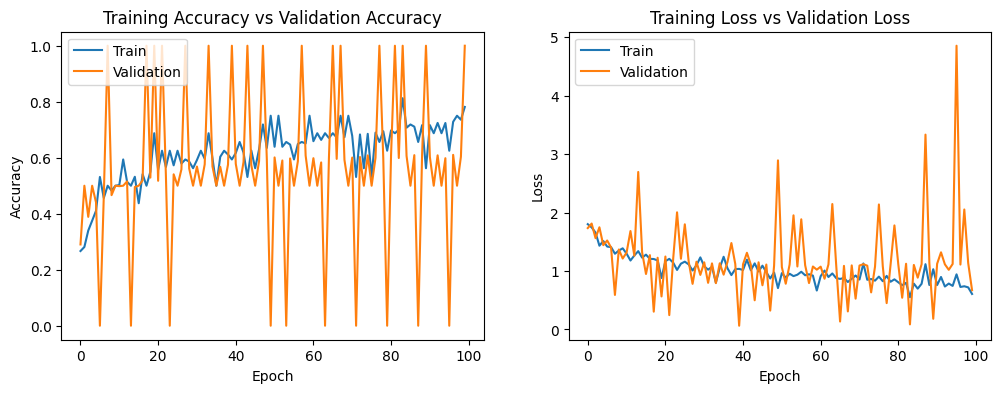

In [14]:
def plot_accuracy_validation(history):
    fig , ax = plt.subplots(1,2)
    train_acc = results.history['accuracy']
    train_loss = results.history['loss']
    fig.set_size_inches(12,4)

    ax[0].plot(results.history['accuracy'])
    ax[0].plot(results.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(results.history['loss'])
    ax[1].plot(results.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()
plot_accuracy_validation(results)


270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step
              precision    recall  f1-score   support

       Anger       0.14      0.14      0.14      1198
     Disgust       0.03      0.02      0.02       130
        Fear       0.14      0.11      0.12      1229
       Happy       0.26      0.33      0.29      2164
     Neutral       0.18      0.16      0.17      1489
     Sadness       0.16      0.16      0.16      1449
    Surprise       0.12      0.09      0.11       951

    accuracy                           0.18      8610
   macro avg       0.15      0.14      0.14      8610
weighted avg       0.17      0.18      0.18      8610



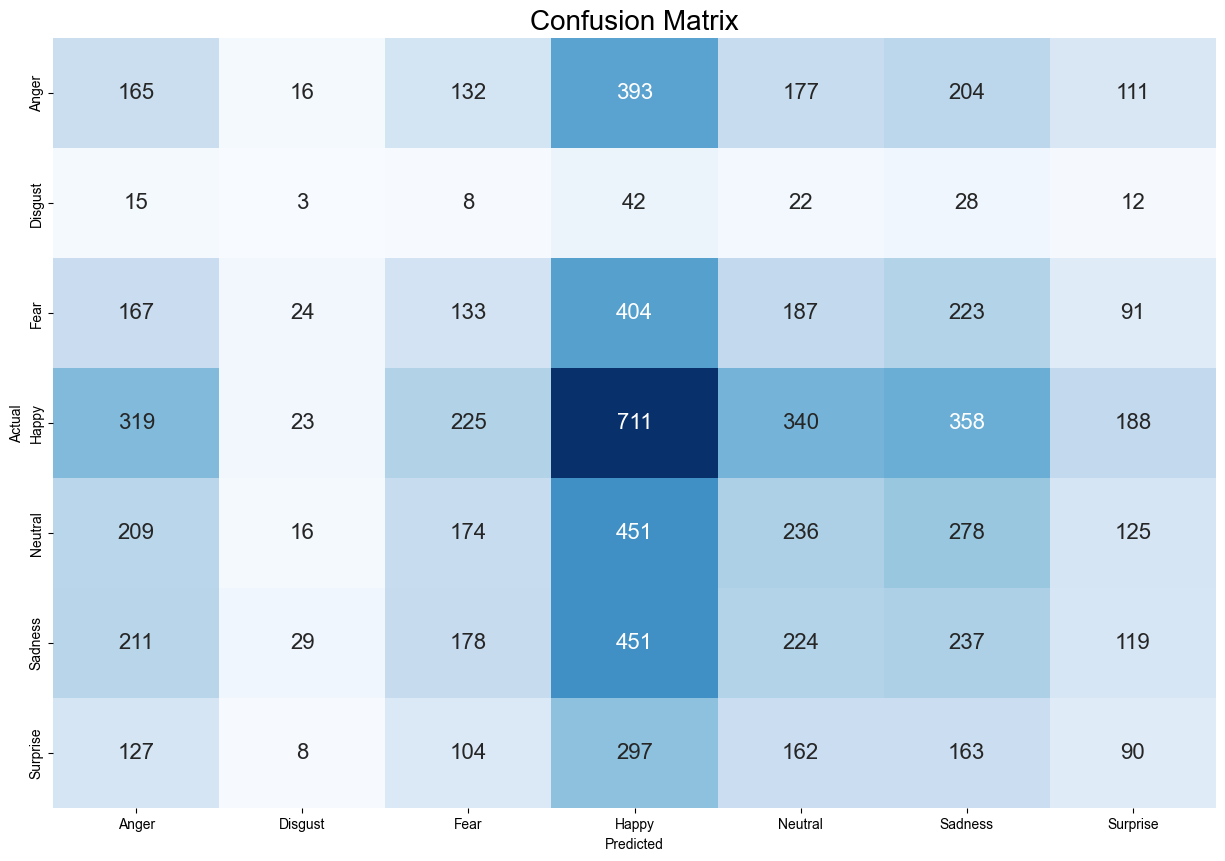

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
Y_pred = model.predict(validation_generator, steps=val_n // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
cm_data = confusion_matrix(validation_generator.classes, y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
target_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('best_fer_model.h5')

# Load an image & preprocess it
img_path = "data/3/sad/image0000311.jpg"  # Change this to your image path
img = image.load_img(img_path, target_size=(48, 48))  # Resize to 48x48
img_array = image.img_to_array(img)

# Convert grayscale if needed
if img_array.shape[-1] == 1:  # Convert grayscale to 3 channels if necessary
    img_array = np.stack((img_array,) * 3, axis=-1)

# Expand dimensions to match batch format
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (only if model was trained with normalization)
img_array = img_array / 255.0  # Normalize if required

# Predict using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class = np.argmax(predictions, axis=1)[0]

# Class labels (should match the order used during training)
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

# Get the class label
predicted_label = CLASS_LABELS[predicted_class]

print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted Class: Sadness
